In [2]:
''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from collections import OrderedDict
import itertools
import numpy as np
import h5py
import timeit
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import xesmf as xe
import glob
import datetime
import calendar
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# these are functions from our homemade code
#from esio import EsioData as ed
from esio import ice_plot
from esio import import_data
from esio import metrics

import dask
#dask.config.set(scheduler='threads')  # overwrite default with threaded scheduler
#from dask.distributed import Client

# General plotting settings
sns.set_style('ticks')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

In [3]:
# customize this cell

# this is where my figures go
fig_dir='/home/disk/sipn/bitz/CambridgeBay/'
CB_lon=[-105.0597]
CB_lat=[ 69.1169]  #69.1169° N, 105.0597° W


In [4]:
#stero_grid_file = E.obs['NSIDC_0051']['grid']

stero_grid_file='/home/disk/sipn/nicway/data/grids/stereo_gridinfo.nc'
obs_grid = import_data.load_grid_info(stero_grid_file, model='NSIDC')

# Ensure latitude is within bounds (-90 to 90)
# Have to do this because grid file has 90.000001
obs_grid['lat_b'] = obs_grid.lat_b.where(obs_grid.lat_b < 90, other = 90)

In [5]:
def MakeModelDataSet(files):
# read in the model data. It has ice concentration (aice) and thickness (hi)
    dm=xr.open_mfdataset(files,decode_times=False)
    dm.coords['fore_time']=('time',(dm.time-dm.time.values[0])/24)
    dm=dm.swap_dims({'time':'fore_time'})
    dm=dm.drop('time')
    cyear = init_time[0:4] 
    cmonth = init_time[4:6]
    cday = init_time[6:8]
    dm.coords['init_time'] = np.datetime64(cyear+'-'+cmonth+'-'+cday)
    dm=dm = dm.assign_coords(lon=(dm.lon % 360)).roll(lon=(dm.dims['lon'] // 2))
    return dm


def MakeDataSet2(FILE_NAME):
    # function for reading the 12.5 km observations of sea ice concentration 

    SIC = '/HDFEOS/GRIDS/NpPolarGrid12km/Data Fields/SI_12km_NH_ICECON_DAY'
    LAT = '/HDFEOS/GRIDS/NpPolarGrid12km/lat'
    LON = '/HDFEOS/GRIDS/NpPolarGrid12km/lon'
    NI = '/XDim'
    NJ = '/YDim'

    f=h5py.File(FILE_NAME, mode='r')
    data = f[SIC][:]
    lat=f[LAT][:]
    lon=f[LON][:]
    ni=f[NI][:]
    nj=f[NJ][:]

    #print(data.shape)
    #print(lat.shape)
    #print(ni.shape)
    #print(nj.shape)

    ds = xr.DataArray(np.transpose(data), dims=["ni", "nj"])
    ds.name = 'sic'
    lat = xr.DataArray(np.transpose(lat), dims=["ni", "nj"])
    lon = xr.DataArray(np.transpose(lon), dims=["ni", "nj"])
    ds=ds.where(ds<=100, other=np.nan)
    ds.coords['lon'] = lon
    ds.coords['lat'] = lat
    ds.coords['nj'] = nj #np.flip(nj)
    ds.coords['ni'] = ni

    result = FILE_NAME.find('he5') 
    date = FILE_NAME[result-9:result-1]
    #print(date, date[0:4], date[4:6], date[6:8])
    cyear = date[0:4] 
    cmonth = date[4:6]
    cday = date[6:8]

    ds.coords['time'] = np.datetime64(cyear+'-'+cmonth+'-'+cday)
    ds.time

    #print('\n\nTake a look at the dataarrray we made \n')
    #print(ds)
    f.close()

    return (ds, lat, lon)

In [6]:
# some pleasant colormaps

cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"], N=10)
cmap_c.set_bad(color = 'lightgrey')

cmap_std = matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10))
cmap_std.set_bad(color = 'lightgrey')

cmap_b =  matplotlib.colors.ListedColormap(sns.color_palette("binary", 2))
cmap_b.set_bad(color = 'None')

No data yet
saved  /home/disk/sipn/bitz/CambridgeBay/SIC_Allyears_2013-2021_0520_forward.png


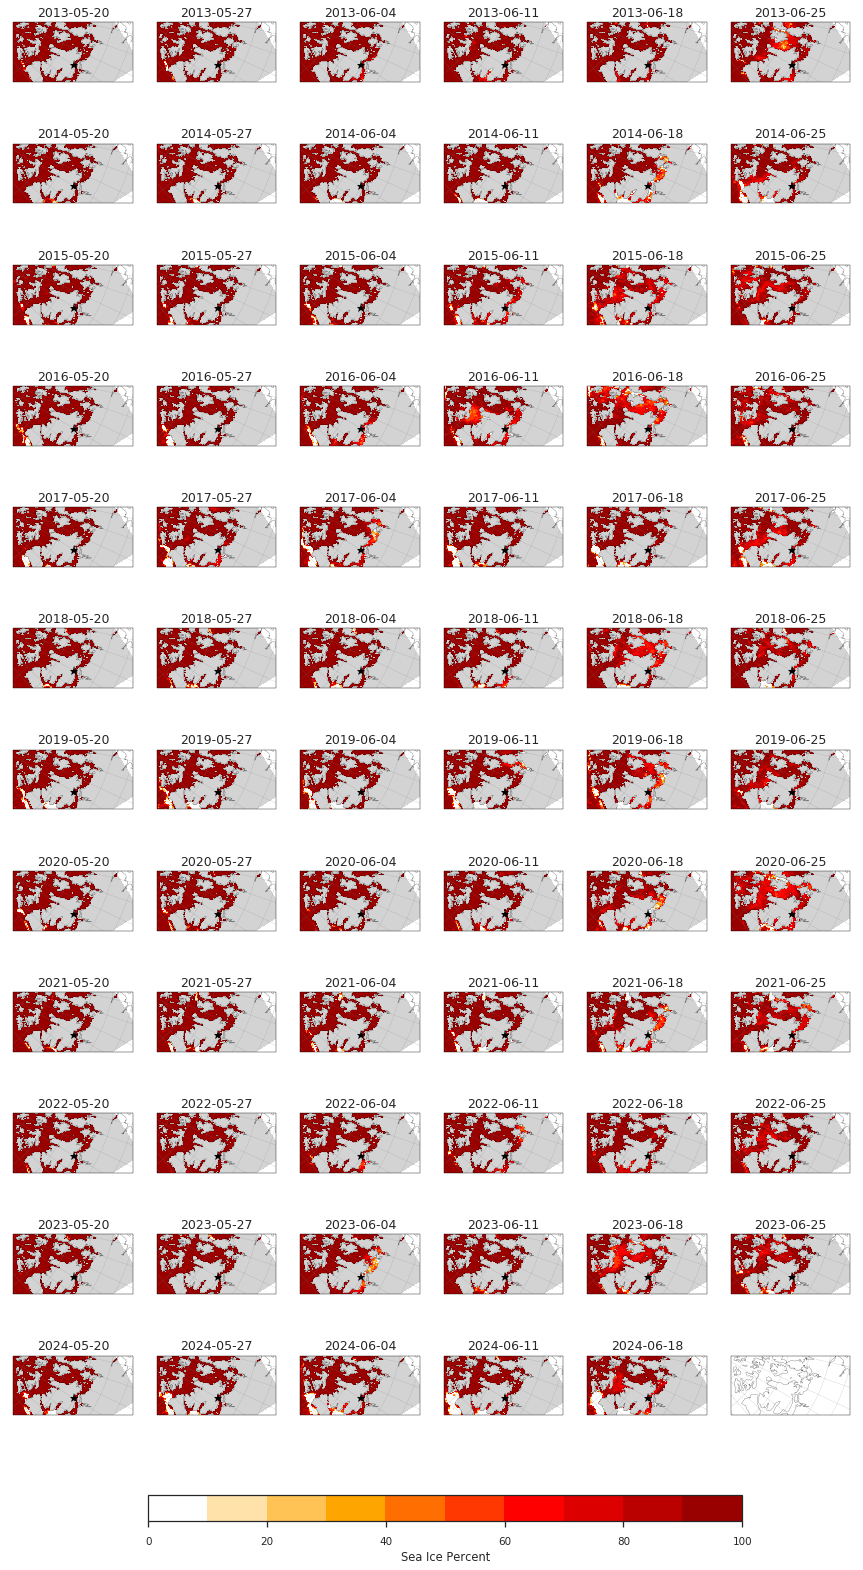

In [32]:
# reads in obs and plots every 5 days as defined by dates array, for every year 2013-2021
dates=['0422','0427','0502','0507']
dates=['0425','0430','0505','0510']
dates=['0502','0507','0512','0517']
dates=['0503','0508','0513','0518']
dates=['0506','0511','0516','0521']
dates=['0506','0511','0516','0521']
dates=['0511','0516','0521','0524']
dates=['0520','0527','0604','0611','0618','0625']


sns.set_context("talk", font_scale=0.8, rc={"lines.linewidth": 2.5})
#kivalina_lon=[-164.5333+.75] # move inland so can see the ocean nearest
#kivalina_lat=[ 67.7269]
kivalina_lon=[-105.0597-3]
kivalina_lat=[ 69.1169]  #69.1169° N, 105.0597° W
f_out = os.path.join(fig_dir,'SIC_Allyears_2013-2021_'+dates[0]+'_forward.png')

c_vmin=0
c_vmax=100

ncols=3
nrows=2021-2013+4
ncols=6
NPLOTS=nrows*ncols+1
sizefcter=2
#crExt = [1800000.0, 2400000.0, -1500000.0, -1000000.0] # (x0, x1, y0, y1) 
crExt = [1000000.0, 3000000.0, -1500000.0, -500000.0] # (x0, x1, y0, y1) 
(f, axes) = ice_plot.multi_polar_axis(ncols=ncols, nrows=nrows, Nplots=NPLOTS, sizefcter=sizefcter, extent=crExt, central_longitude=193-360)
f.set_size_inches(ncols*2.5, nrows*2) # tinker a bit

i=0
for yr in np.arange(2013,2025):
    for j in np.arange(0,6):
        date=dates[j]
        FILE_NAME = '/home/disk/sipn/nicway/data/obs/AMSR_U2/native/AMSR_U2_L3_SeaIce12km_B04_'+str(yr)+date+'.he5'
        try:
            sic, lat, lon = MakeDataSet2(FILE_NAME)
            sic= sic.isel(nj=slice(420,625)).isel(ni=slice(100,240))

            axi=axes[i]
            p = sic.plot.pcolormesh(ax=axi, x='lon', y='lat', 
                          transform=ccrs.PlateCarree(), add_colorbar=False,
                          cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)
            axi.plot([kivalina_lon], [kivalina_lat], color='k', marker='*',
                         transform=ccrs.PlateCarree())  # because using lon, lat                
            axi.set_title("{Y}-{M}-{D}".format(Y=str(yr),M=date[0:2],D=date[2:4]))
        except:
            print('No data yet')
        i=i+1

    f.subplots_adjust(bottom=0.05)
cbar_ax = f.add_axes([0.25, 0.001, .55, 0.015]) #  [left, bottom, width, height] w
cbar = f.colorbar(p, cax=cbar_ax, label=
                  'Sea Ice Percent', orientation='horizontal')

# Save to file
f.savefig(f_out,bbox_inches='tight', dpi=300)
print("saved ", f_out)


saved  /home/disk/sipn/bitz/CambridgeBay/SIC_Allyears_2013-2021_0520_forward.png


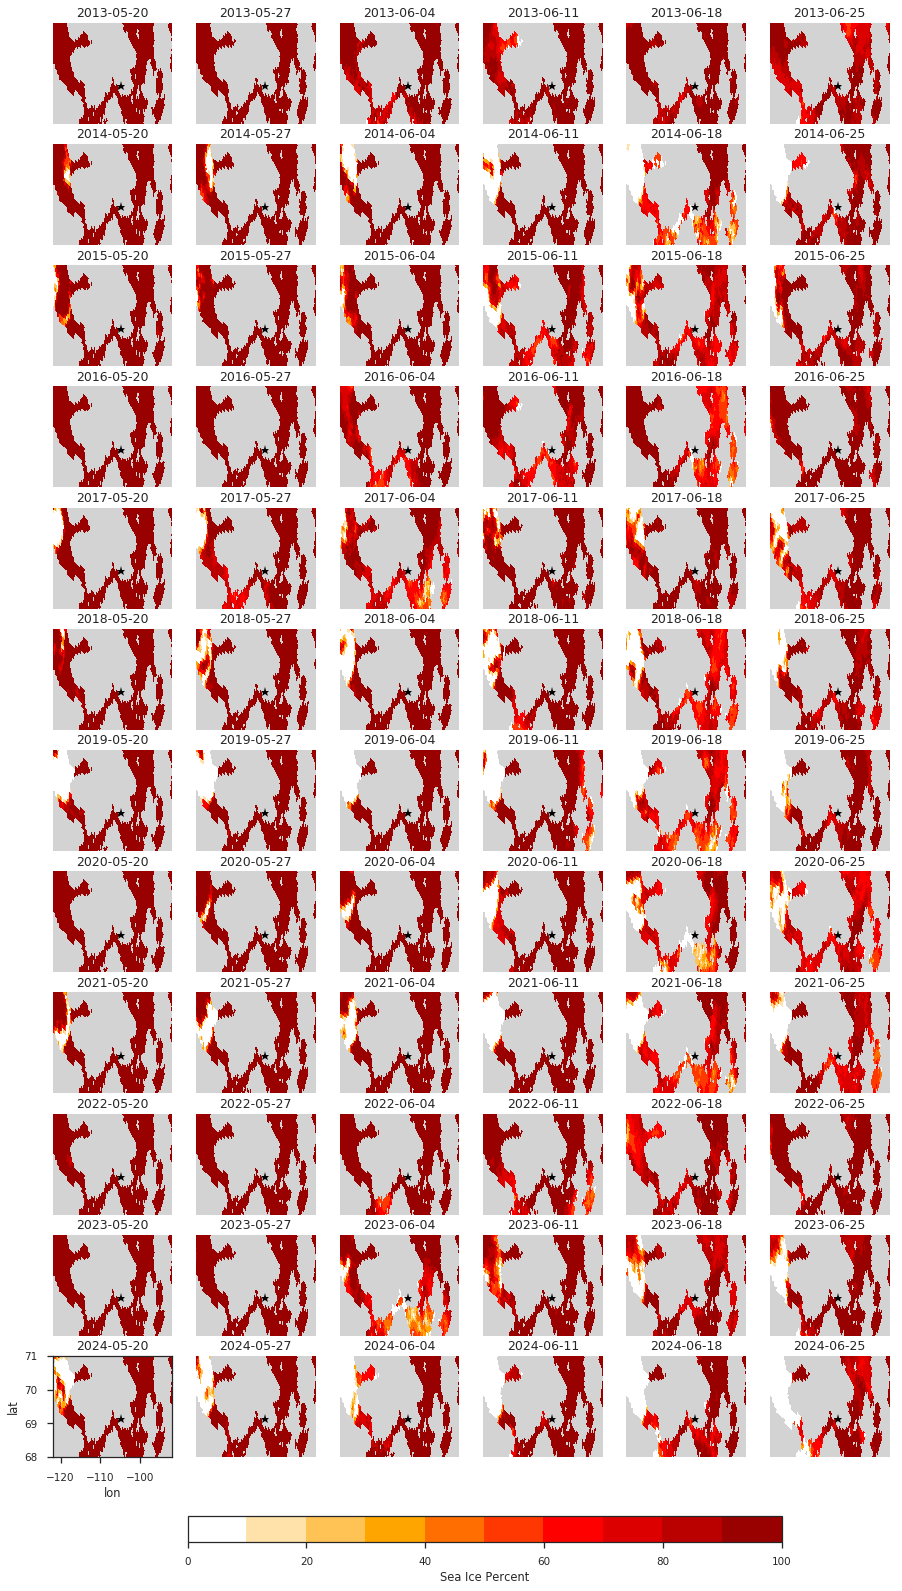

In [78]:
# reads in obs and plots every 7 days as defined by dates array, for every year 2013-2024
dates=['0520','0527','0604','0611','0618','0625']


sns.set_context("talk", font_scale=0.8, rc={"lines.linewidth": 2.5})
#kivalina_lon=[-164.5333+.75] # move inland so can see the ocean nearest
#kivalina_lat=[ 67.7269]

kivalina_lon=CB_lon+0.25
kivalina_lat=CB_lat  #69.1169° N, 105.0597° W
f_out = os.path.join(fig_dir,'SIC_Allyears_2013-2021_'+dates[0]+'_forward.png')

c_vmin=0
c_vmax=100

ncols=3
nrows=2021-2013+4
ncols=6
NPLOTS=nrows*ncols+1
sizefcter=2
#crExt = [1800000.0, 2400000.0, -1500000.0, -1000000.0] # (x0, x1, y0, y1) 
crExt = [1000000.0, 3000000.0, -1500000.0, -500000.0] # (x0, x1, y0, y1) 
(f, axes) = plt.subplots(ncols=ncols, nrows=nrows)
f.set_size_inches(ncols*2.5, nrows*2) # tinker a bit
axes=axes.flatten()
i=0
for yr in np.arange(2013,2025):
    for j in np.arange(0,6):
        date=dates[j]
        FILE_NAME = '/home/disk/sipn/nicway/data/obs/AMSR_U2/native/AMSR_U2_L3_SeaIce12km_B04_'+str(yr)+date+'.he5'
#        try:
        sic, lat, lon = MakeDataSet2(FILE_NAME)
        #sic= sic.isel(nj=slice(420,625)).isel(ni=slice(100,240))
        sic= sic.isel(nj=slice(500,605)).isel(ni=slice(110,190))

        axi=axes[i]
        p=sic.plot(ax=axi, x='lon', y='lat', add_colorbar=False,
                      cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)
        axi.set_ylim([68, 71])
        axi.set_xlim([-122, -92])
        if i!=13*5+1:
            axi.axis('off')
        axi.plot([kivalina_lon], [kivalina_lat], color='k', marker='*')
        axi.set_title("{Y}-{M}-{D}".format(Y=str(yr),M=date[0:2],D=date[2:4]))
#        except:
#            print('No data yet')
        i=i+1

    f.subplots_adjust(bottom=0.05)
cbar_ax = f.add_axes([0.25, 0.001, .55, 0.015]) #  [left, bottom, width, height] w
cbar = f.colorbar(p, cax=cbar_ax, label=
                  'Sea Ice Percent', orientation='horizontal')

# Save to file
f.savefig(f_out,bbox_inches='tight', dpi=300)
print("saved ", f_out)


In [64]:
IFD_all=[]
IFD2_all=[]
sic_CB = []
for yr in np.arange(2013,2025):
    sic_all=[]
    for mo in np.arange(5,10):
        for day in np.arange(1,32):
            mostr = "{:02d}".format(mo)
            daystr= "{:02d}".format(day)
            FILE_NAME = '/home/disk/sipn/nicway/data/obs/AMSR_U2/native/AMSR_U2_L3_SeaIce12km_B04_'+str(yr)+mostr+daystr+'.he5'
            try:
                sic, lat, lon = MakeDataSet2(FILE_NAME)
                sic= sic.isel(nj=slice(500,605)).isel(ni=slice(110,190))
                sic = sic.expand_dims('time')
                sic_all.append(sic)
            except:
                if yr == 2013 and mo==5 and day in [11, 12, 13]:
                    print('one of these days')
                    sic['time']=sic['time']+np.timedelta64(1, 'D')
                    sic_all.append(sic)
                    ni=sic.ni
                    nj=sic.nj
                print('no data found'+FILE_NAME)

    sic_all = xr.concat(sic_all, dim='time')
    if yr>2022: # strange that the data sets lose this 
        sic_all['ni']=ni
        sic_all['nj']=nj

    sic_CB.append(sic_all.sel(ni=148,nj=558))

    DOY = np.arange(121,121+len(sic_all['time']))
    sic_all.coords['doy'] = xr.DataArray(DOY, dims='time', coords={'time':sic_all.time})

    sic_IFD = metrics.calc_IFD(sic_all/100,sic_threshold=0.70, DOY_s=121) 
    sic_IFD2 = metrics.calc_IFD_10day(sic_all/100,sic_threshold=0.5, DOY_s=121, Nday=6) 
    sic_IFD.name ='IFD'
    sic_IFD2.name ='IFD2'

    #sic_IFD=sic_IFD.where(((sic_IFD>122) | (np.isnan(sic_IFD))), other=sic_IFD.max()) 
    sic_IFD=sic_IFD.expand_dims('time')
    sic_IFD2=sic_IFD2.expand_dims('time')

    IFD_all.append(sic_IFD)
    IFD2_all.append(sic_IFD2)


IFD_all = xr.concat(IFD_all, dim='time')
IFD_all.coords['year'] = xr.DataArray(np.arange(2013,2025), dims='time', coords={'time':IFD_all.time})
IFD_all=IFD_all.swap_dims({"time": "year"})
IFD2_all = xr.concat(IFD2_all, dim='time')
IFD2_all.coords['year'] = xr.DataArray(np.arange(2013,2025), dims='time', coords={'time':IFD2_all.time})
IFD2_all=IFD2_all.swap_dims({"time": "year"})
IFD2_all=IFD2_all.astype(float)

sic_CB = xr.concat(sic_CB, dim='time')
#sic_CB = sic_CB.coords['year'] = xr.DataArray(np.arange(2013,2025), dims='time', coords={'time':sic_CB.time})

IFD_all

one of these days
no data found/home/disk/sipn/nicway/data/obs/AMSR_U2/native/AMSR_U2_L3_SeaIce12km_B04_20130511.he5
one of these days
no data found/home/disk/sipn/nicway/data/obs/AMSR_U2/native/AMSR_U2_L3_SeaIce12km_B04_20130512.he5
one of these days
no data found/home/disk/sipn/nicway/data/obs/AMSR_U2/native/AMSR_U2_L3_SeaIce12km_B04_20130513.he5
no data found/home/disk/sipn/nicway/data/obs/AMSR_U2/native/AMSR_U2_L3_SeaIce12km_B04_20130631.he5
no data found/home/disk/sipn/nicway/data/obs/AMSR_U2/native/AMSR_U2_L3_SeaIce12km_B04_20130931.he5
no data found/home/disk/sipn/nicway/data/obs/AMSR_U2/native/AMSR_U2_L3_SeaIce12km_B04_20140631.he5
no data found/home/disk/sipn/nicway/data/obs/AMSR_U2/native/AMSR_U2_L3_SeaIce12km_B04_20140931.he5
no data found/home/disk/sipn/nicway/data/obs/AMSR_U2/native/AMSR_U2_L3_SeaIce12km_B04_20150631.he5
no data found/home/disk/sipn/nicway/data/obs/AMSR_U2/native/AMSR_U2_L3_SeaIce12km_B04_20150931.he5
no data found/home/disk/sipn/nicway/data/obs/AMSR_U2/na

<xarray.DataArray 'IFD' (year: 12, ni: 80, nj: 105)>
array([[[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ...,
        [229., 230., ..., 121., 270.],
        [229., 234., ..., 270., 269.]],

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ...,
        [215., 218., ..., 232., 232.],
        [218., 225., ..., 232., 232.]],

       ...,

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ...,
        [169., 169., ..., 230., 230.],
        [136., 169., ..., 232., 230.]],

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ...,
        [162., 162., ..., 249., 246.],
        [166., 166., ..., 251., 250.]]])
Coordinates:
    lon      (ni, nj) float32 -125.65533 -125.3731 ... -86.17095 -85.96229
    lat      (ni, nj) float32 67.1979 67.179596 67.16076 ... 69.44372 69.3594
  * nj       (nj) int32 500 501 502 503 504 505 506 ... 599 600 601 602 603 604
  * 

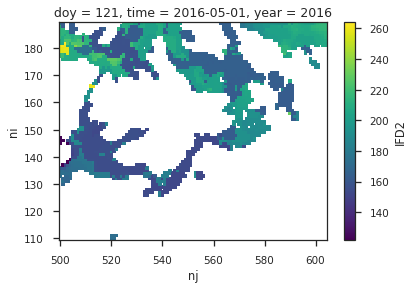

In [32]:
IFD2_all.sel(year=2016).plot()

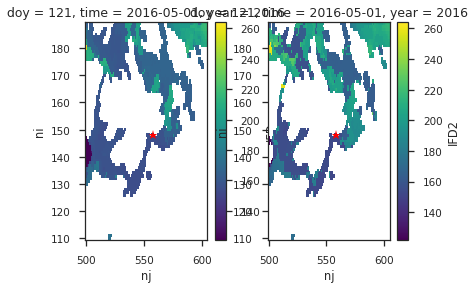

In [35]:
#IFD_all.mean(dim='year').plot()
plt.subplot(121)
IFD_all.sel(year=2016).plot()
plt.plot(558,148, color='r', marker='*')
plt.subplot(122)
IFD2_all.sel(year=2016).plot()
plt.plot(558,148, color='r', marker='*')

saved  /home/disk/sipn/bitz/CambridgeBay/IFD2_Allyears_2013-2024.png


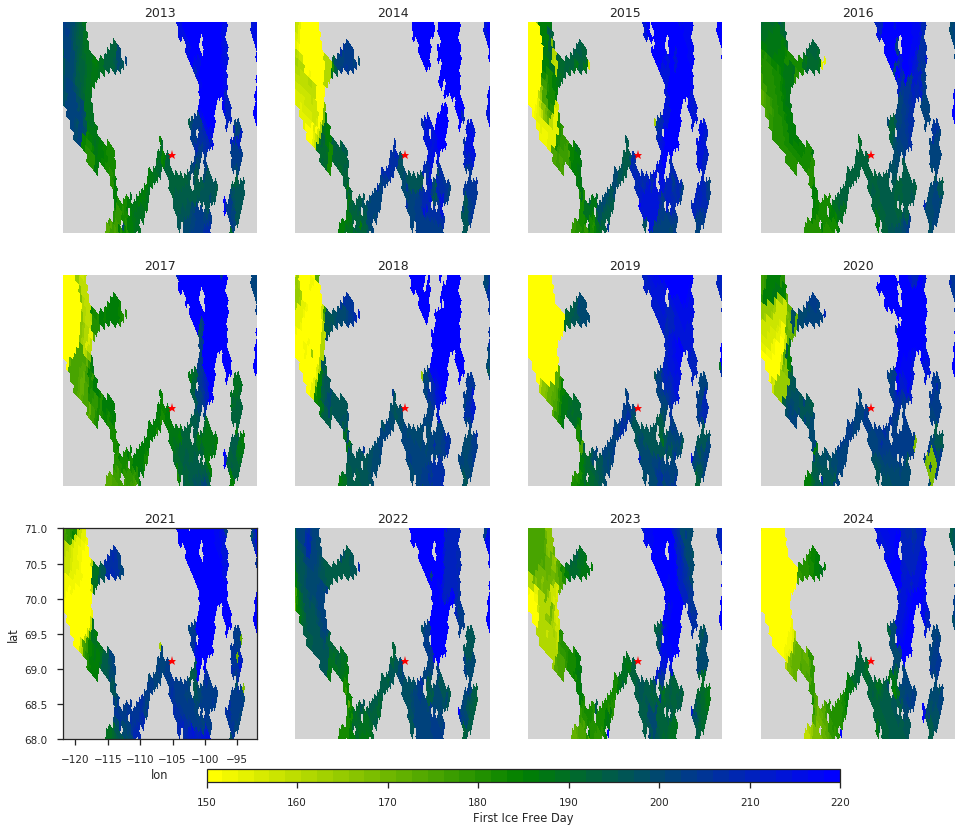

In [79]:
cmap_i = matplotlib.colors.LinearSegmentedColormap.from_list("", ["yellow","green","blue"], N=40)
cmap_i.set_bad(color = 'lightgrey')

ncols=4
nrows=3
(f, axes) = plt.subplots(ncols=ncols, nrows=nrows)
f.set_size_inches(ncols*4, nrows*4) # tinker a bit
axes=axes.flatten()
i=0
for i,yr in enumerate(np.arange(2013,2025)):
    axi=axes[i]
    p=IFD2_all.sel(year=yr).plot(ax=axi, x='lon',y='lat', vmin=150, vmax=220, add_colorbar=False, cmap=cmap_i)
    axi.plot([CB_lon], [CB_lat], color='r', marker='*')
    #axi.plot(-105.429504, 69.06595, color='r', marker='*') # this is where the closes ocean point is but blocks view
    axi.set_ylim([67,71])
    axi.set_xlim([-120,-95])
    axi.set_ylim([68, 71])
    axi.set_xlim([-122, -92])
    
    axi.set_title(str(yr))
    if i != 8:
        axi.axis('off')
    f.subplots_adjust(bottom=0.05)
cbar_ax = f.add_axes([0.25, 0.001, .55, 0.015]) #  [left, bottom, width, height] w
cbar = f.colorbar(p, cax=cbar_ax, label=
                  'First Ice Free Day', orientation='horizontal')

f_out = os.path.join(fig_dir,'IFD2_Allyears_2013-2024.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)
print("saved ", f_out)


saved  /home/disk/sipn/bitz/CambridgeBay/Cambridge_Bay_IFD_2013-2024.png


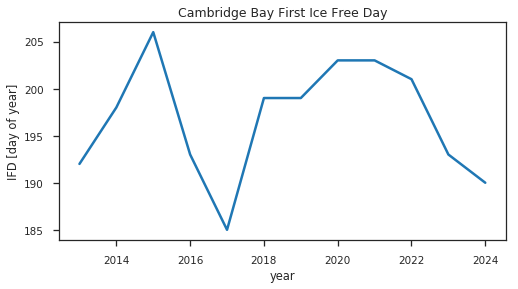

In [83]:
(fig, axes) = plt.subplots(1,1)
fig.set_size_inches(8,4)
IFD2_all.sel(ni=148,nj=558).plot()
#print(IFD_all.sel(year=2014).sel(ni=148,nj=558))  # these are the loses ni,nj
plt.title("Cambridge Bay First Ice Free Day")
plt.ylabel("IFD [day of year]")
f_out = os.path.join(fig_dir,'Cambridge_Bay_IFD_2013-2024.png')
fig.savefig(f_out,bbox_inches='tight', dpi=300)
print("saved ", f_out)


In [68]:
yr=2016
sic_all=[]
for mo in np.arange(5,10):
    for day in np.arange(1,32):
        mostr = "{:02d}".format(mo)
        daystr= "{:02d}".format(day)
        FILE_NAME = '/home/disk/sipn/nicway/data/obs/AMSR_U2/native/AMSR_U2_L3_SeaIce12km_B04_'+str(yr)+mostr+daystr+'.he5'
        try:
            sic, lat, lon = MakeDataSet2(FILE_NAME)
            sic= sic.isel(nj=slice(500,605)).isel(ni=slice(110,190))
            sic = sic.expand_dims('time')
            sic_all.append(sic)
        except:
            if yr == 2013 and mo==5 and day in [11, 12, 13]:
                print('one of these days')
                sic['time']=sic['time']+np.timedelta64(1, 'D')
                sic_all.append(sic)
                ni=sic.ni
                nj=sic.nj
            print('no data found'+FILE_NAME)

sic_all = xr.concat(sic_all, dim='time')
DOY = np.arange(121,121+len(sic_all['time']))
sic_all.coords['doy'] = xr.DataArray(DOY, dims='time', coords={'time':sic_all.time})

sic_all

no data found/home/disk/sipn/nicway/data/obs/AMSR_U2/native/AMSR_U2_L3_SeaIce12km_B04_20160631.he5
no data found/home/disk/sipn/nicway/data/obs/AMSR_U2/native/AMSR_U2_L3_SeaIce12km_B04_20160931.he5


<xarray.DataArray 'sic' (time: 153, ni: 80, nj: 105)>
array([[[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ...,
        [ 97.,  99., ..., 100., 100.],
        [ 99.,  99., ..., 100., 100.]],

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ...,
        [ 96.,  98., ..., 100., 100.],
        [ 97.,  99., ..., 100., 100.]],

       ...,

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ...,
        [ 93.,  97., ...,   0.,   0.],
        [ 92.,  92., ...,   0.,   0.]],

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ...,
        [ 94.,  97., ...,   0.,   0.],
        [ 94.,  93., ...,   0.,   0.]]])
Coordinates:
    lon      (ni, nj) float32 -125.65533 -125.3731 ... -86.17095 -85.96229
    lat      (ni, nj) float32 67.1979 67.179596 67.16076 ... 69.44372 69.3594
  * nj       (nj) int32 500 501 502 503 504 505 506 ... 599 600 601 602 603 604
  *

saved  /home/disk/sipn/bitz/CambridgeBay/Cambridge_Bay_SIC_MaytoJuly_2013-2024.png


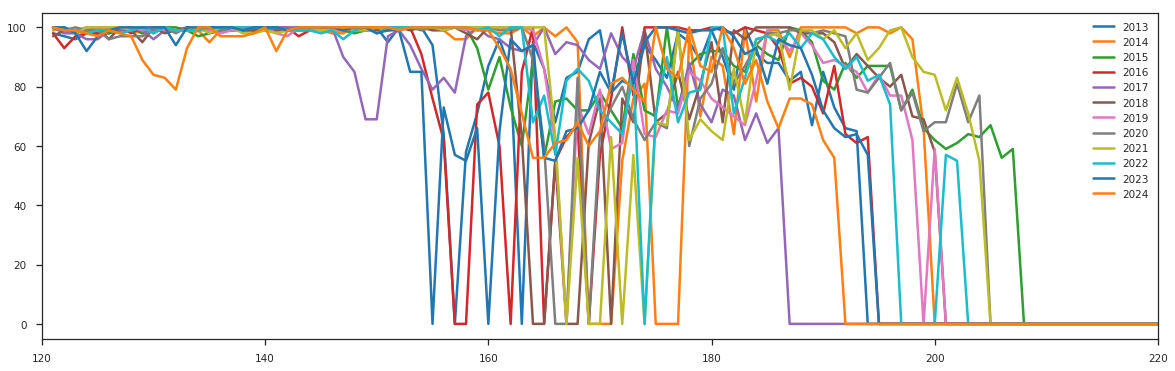

In [86]:
(fig, axes) = plt.subplots(1,1)
fig.set_size_inches(20,6)
for yr in np.arange(2013,2025):
    plt.plot(DOY,sic_CB[pd.to_datetime(sic_CB.time.data).year==yr],label=str(yr))
plt.xlim([120,220])
plt.legend()
plt.ylabel('Sea Ice Concentration [%]')
plt.xlabel
f_out = os.path.join(fig_dir,'Cambridge_Bay_SIC_MaytoJuly_2013-2024.png')
fig.savefig(f_out,bbox_inches='tight', dpi=300)
print("saved ", f_out)


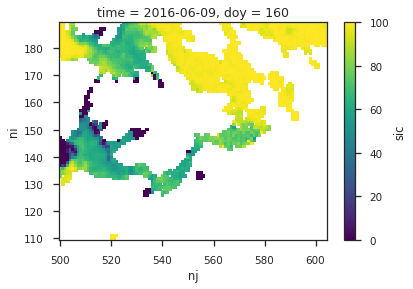

In [54]:
sic_all.isel(time=159-120).plot() # obiously there are bad points occuring in bays and channels

<xarray.DataArray 'IFD' ()>
array(169.)
Coordinates:
    lon      float32 -105.429504
    lat      float32 69.06595
    nj       int32 558
    ni       int32 148
    doy      int64 121
    time     datetime64[ns] 2014-05-01
    year     int64 2014


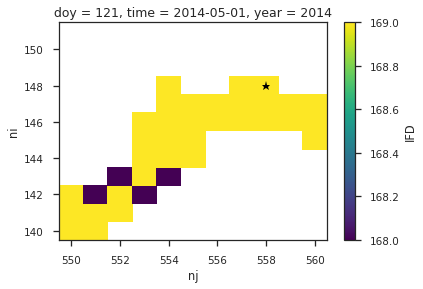

In [146]:
IFD_all.isel(year=1).sel(ni=range(140,152),nj=range(550,561)).plot()
print(IFD_all.sel(year=2014).sel(ni=148,nj=558))  # these are the loses ni,nj
plt.plot(558,148, color='k', marker='*')

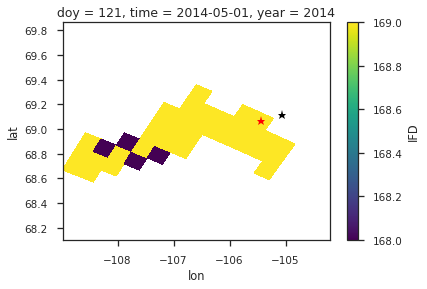

In [148]:
IFD_all.isel(year=1).sel(ni=range(140,152),nj=range(550,561)).plot(x='lon',y='lat')
plt.plot([CB_lon], [CB_lat], color='k', marker='*')
plt.plot(-105.429504, 69.06595, color='r', marker='*')

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


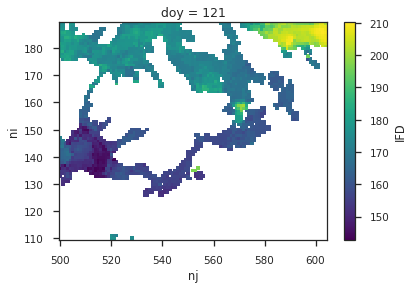

In [107]:
IFD_all.mean(dim='year').plot()

In [30]:
# Calc observed Ice Free Day
# masking is not quite right
da_IFD2 = ds_81.groupby('time.year').apply(metrics.calc_IFD_10day, sic_threshold=0.5, Nday=10 )
da_IFD2.name = 'IFD'

ifd_all2=[]  

for y in ObsYears:
    tmp=ds_81.sel(time=str(y)).min(dim='time') # min sic at anytime during year
    ifd = da_IFD2.sel(year=y).where(tmp<0.5, other=c_vmax) # if never below 0.5 at anytime then set to max poss
    ifd_all2.append(ifd)

ifd_all2=xr.concat(ifd_all2, dim='year')

#climo2=ifd_all2.mean(dim='year')
climo2 = ifd_all2.where(ds_81.isel(time=10).notnull()) # Apply Orig mask 

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/e

### THE CODE LOOKS LIKE

ds_ifd = metrics.calc_IFD_10day(ds_model, sic_threshold=0.5, DOY_s=DOY_first_vt[0], time_dim='fore_time', 
                                Nday=10, default_ice_free=pd.to_datetime('2019-06-01').timetuple().tm_yday)

Coordinates:
    lon         (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    lat         (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
  * fore_time   (fore_time) timedelta64[ns] 0 days 1 days ... 59 days 60 days
  * init_time   (init_time) datetime64[ns] 2019-08-01
    valid_time  (init_time, fore_time) datetime64[ns] 2019-08-01 ... 2019-09-30

In [31]:
climo2

<xarray.DataArray (year: 10, y: 448, x: 304)>
dask.array<shape=(10, 448, 304), dtype=object, chunksize=(1, 448, 304)>
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
  * year     (year) int64 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019

In [33]:
ifd_all2=[]  # need to deal with years when never get below 0.15

for y in ObsYears:
    print('Operating on Year ',y)
    tmpo=ds_81.sel(time=str(y))
    
    first_day = np.datetime64(datetime.datetime(int(y),6,1))
    last_day = np.datetime64(datetime.datetime(int(y),10,1))
    print("Looking for times between",first_day,"and",last_day)

    tmpo = tmpo.sel(time=slice(first_day,last_day))
    
    tmp=tmpo.min(dim='time') # min sic at anytime during year
    
    DOY_first_vt = [x.timetuple().tm_yday for x in pd.to_datetime([tmpo.time.min().values])]
    print(DOY_first_vt[0])
    tmpo['time'] = tmpo.time - tmpo.time[0]
    print(tmpo)

    # setting the default_ice_free value equal to c_vmin is important
    ifd = metrics.calc_IFD_10day(tmpo, sic_threshold=0.5, DOY_s=DOY_first_vt[0], time_dim='time', 
                                    Nday=10, default_ice_free=pd.to_datetime(str(y)+'-06-01').timetuple().tm_yday)


    ifd_all2.append(ifd)

ifd_all2=xr.concat(ifd_all2, dim='year')

#climo3 =ifd_all2.mean(dim='year')
climo3 = ifd_all2.where(ds_81.isel(time=10).notnull()) # Apply Orig mask 



Operating on Year  2010
Looking for times between 2010-06-01T00:00:00.000000 and 2010-10-01T00:00:00.000000
152
<xarray.DataArray 'sic' (time: 123, y: 448, x: 304)>
dask.array<shape=(123, 448, 304), dtype=float64, chunksize=(123, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 121 days 122 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2010 2010 2010 2010 2010 ... 2010 2010 2010 2010 2010
    doy      (time) int64 152 153 154 155 156 157 ... 269 270 271 272 273 274


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Operating on Year  2011
Looking for times between 2011-06-01T00:00:00.000000 and 2011-10-01T00:00:00.000000
152
<xarray.DataArray 'sic' (time: 123, y: 448, x: 304)>
dask.array<shape=(123, 448, 304), dtype=float64, chunksize=(123, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 121 days 122 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2011 2011 2011 2011 2011 ... 2011 2011 2011 2011 2011
    doy      (time) int64 152 153 154 155 156 157 ... 269 270 271 272 273 274


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Operating on Year  2012
Looking for times between 2012-06-01T00:00:00.000000 and 2012-10-01T00:00:00.000000
153
<xarray.DataArray 'sic' (time: 123, y: 448, x: 304)>
dask.array<shape=(123, 448, 304), dtype=float64, chunksize=(123, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 121 days 122 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2012 2012 2012 2012 2012 ... 2012 2012 2012 2012 2012
    doy      (time) int64 153 154 155 156 157 158 ... 270 271 272 273 274 275


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Operating on Year  2013
Looking for times between 2013-06-01T00:00:00.000000 and 2013-10-01T00:00:00.000000
152
<xarray.DataArray 'sic' (time: 123, y: 448, x: 304)>
dask.array<shape=(123, 448, 304), dtype=float64, chunksize=(123, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 121 days 122 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2013 2013 2013 2013 2013 ... 2013 2013 2013 2013 2013
    doy      (time) int64 152 153 154 155 156 157 ... 269 270 271 272 273 274


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Operating on Year  2014
Looking for times between 2014-06-01T00:00:00.000000 and 2014-10-01T00:00:00.000000
152
<xarray.DataArray 'sic' (time: 123, y: 448, x: 304)>
dask.array<shape=(123, 448, 304), dtype=float64, chunksize=(123, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 121 days 122 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2014 2014 2014 2014 2014 ... 2014 2014 2014 2014 2014
    doy      (time) int64 152 153 154 155 156 157 ... 269 270 271 272 273 274


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Operating on Year  2015
Looking for times between 2015-06-01T00:00:00.000000 and 2015-10-01T00:00:00.000000
152
<xarray.DataArray 'sic' (time: 123, y: 448, x: 304)>
dask.array<shape=(123, 448, 304), dtype=float64, chunksize=(123, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 121 days 122 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2015 2015 2015 2015 2015 ... 2015 2015 2015 2015 2015
    doy      (time) int64 152 153 154 155 156 157 ... 269 270 271 272 273 274


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Operating on Year  2016
Looking for times between 2016-06-01T00:00:00.000000 and 2016-10-01T00:00:00.000000
153
<xarray.DataArray 'sic' (time: 123, y: 448, x: 304)>
dask.array<shape=(123, 448, 304), dtype=float64, chunksize=(123, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 121 days 122 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2016 2016 2016 2016 2016 ... 2016 2016 2016 2016 2016
    doy      (time) int64 153 154 155 156 157 158 ... 270 271 272 273 274 275


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Operating on Year  2017
Looking for times between 2017-06-01T00:00:00.000000 and 2017-10-01T00:00:00.000000
152
<xarray.DataArray 'sic' (time: 123, y: 448, x: 304)>
dask.array<shape=(123, 448, 304), dtype=float64, chunksize=(123, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 121 days 122 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2017 2017 2017 2017 2017 ... 2017 2017 2017 2017 2017
    doy      (time) int64 152 153 154 155 156 157 ... 269 270 271 272 273 274


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Operating on Year  2018
Looking for times between 2018-06-01T00:00:00.000000 and 2018-10-01T00:00:00.000000
152
<xarray.DataArray 'sic' (time: 123, y: 448, x: 304)>
dask.array<shape=(123, 448, 304), dtype=float64, chunksize=(123, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 121 days 122 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2018 2018 2018 2018 2018 ... 2018 2018 2018 2018 2018
    doy      (time) int64 152 153 154 155 156 157 ... 269 270 271 272 273 274


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


Operating on Year  2019
Looking for times between 2019-06-01T00:00:00.000000 and 2019-10-01T00:00:00.000000
152
<xarray.DataArray 'sic' (time: 123, y: 448, x: 304)>
dask.array<shape=(123, 448, 304), dtype=float64, chunksize=(123, 448, 304)>
Coordinates:
  * time     (time) timedelta64[ns] 0 days 1 days 2 days ... 121 days 122 days
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    year     (time) int64 2019 2019 2019 2019 2019 ... 2019 2019 2019 2019 2019
    doy      (time) int64 152 153 154 155 156 157 ... 269 270 271 272 273 274


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)


<xarray.DataArray (year: 10, y: 448, x: 304)>
dask.array<shape=(10, 448, 304), dtype=float64, chunksize=(1, 448, 304)>
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
  * year     (year) int64 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019

In [7]:
#cmap_std = matplotlib.colors.LinearSegmentedColormap.from_list('redhues', redhues, N=8)
cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"], N=10)
cmap_c.set_bad(color = 'lightgrey')


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


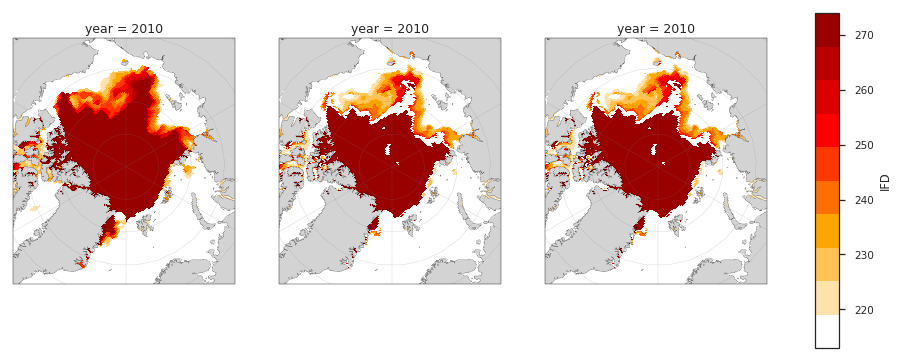

In [39]:
NPLOTS = 4
year=2010
c_vmin=213
#central_extent = [-3850000, 3725000, -5325000, 5850000] # (x0, x1, y0, y1
central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1

(f, axes) = ice_plot.multi_polar_axis(ncols=3, nrows=1, Nplots=NPLOTS, sizefcter=3, extent=central_extent, central_longitude=0)

i=0
p = climo.sel(year=year).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_c,
                          vmin=c_vmin, vmax=c_vmax)


i=1
p = climo2.sel(year=year).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_c,
                          vmin=c_vmin, vmax=c_vmax)


i=2
p = climo3.sel(year=year).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_c,
                          vmin=c_vmin, vmax=c_vmax)



cbar_ax = f.add_axes([0.95, 0.07, .025, 0.775]) #  [left, bottom, width, height] w
c_label = 'IFD'
cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='vertical')

In [38]:
print(c_vmin,c_vmax)

213 274


In [ ]:
    # Plot perenial ice as black
    #cper_mask = ds_IFD_All.sel(model=cmod)
    pb = cper_mask.where(cper_mask==275).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_b,
                          vmin=0, vmax=1)    
    
    add_subplot_title(cmod, custom_names, E, ax=axes[i])

    # Add init date
#    axes[i].annotate(pd.to_datetime(ds_IFD_All.sel(model=cmod).init_date.values).strftime('%m/%d'), xy=(.6, -.15), xycoords='axes fraction', )

# MME Mean
i = i + 1

cper_mask = ds_MME_avg.isel(init_time=0)

pmme = cper_mask.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c, vmin=c_vmin, vmax=c_vmax)

# Plot perenial ice as black
pb = cper_mask.where(cper_mask>=274).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                      transform=ccrs.PlateCarree(),
                      add_colorbar=False,
                      cmap=cmap_b,
                      vmin=0, vmax=1)    


axes[i].set_title('Multi-Forecast\nMean')


PlotObs = True
if PlotObs:       
    print('Climo 10 yr')
    # Climo10yrs
    i = i + 1

    pmme = climo.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                      transform=ccrs.PlateCarree(),
                                      add_colorbar=False, 
                                      cmap=cmap_c, vmin=c_vmin, vmax=c_vmax)

    # Plot perenial ice as black
    pb = climo.where(climo>=274).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_b,
                          vmin=0, vmax=1)    


    axes[i].set_title('Climatology\nLast 10 yrs')
    

# MME Standard deviation
i = i + 1

print('MME sigma')

fld = ds_MME_std.isel(init_time=0)
landmask = fld.notnull()
fld = fld.where(cper_mask>c_vmin,other=0)
fld = fld.where(landmask)

pstd = fld.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_std,vmin=ds_MME_std.min().values, vmax=ds_MME_std.max().values)
axes[i].set_title('σ of\nForecasts')



# Make pretty
f.subplots_adjust(bottom=0.05)

cbar1vertical = True
if cbar1vertical:
#    cbar_ax = f.add_axes([0.95, 0.36, .05, 0.5]) #  [left, bottom, width, height]   span just top rows
    cbar_ax = f.add_axes([0.95, 0.07, .025, 0.775]) #  [left, bottom, width, height] w
    cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='vertical')
else:
    cbar_ax = f.add_axes([0.25, 0.001, .5, 0.04]) #  [left, bottom, width, height] w
    cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='horizontal')
cbar.set_ticks(DOY_months)
cbar.set_ticklabels(DOY_labels)

#f.subplots_adjust(right=0.05)
#cbar_ax_2 = f.add_axes([0.925, 0.1, .025, .28]) #  [left, bottom, width, height] w   FAR RIGHT
#cbar_ax_2 = f.add_axes([0.75, 0.1, .025, .28]) #  [left, bottom, width, height] w
#cbar_ax_2 = f.add_axes([0.35, 0.07, .025, .20]) #  [left, bottom, width, height] w

#cbar_ax_2 = f.add_axes([0.76, 0.07, .025, .20]) #  [left, bottom, width, height] w
cbar_ax_2 = f.add_axes([0.53, 0.08, .025, .18]) #  [left, bottom, width, height] w

cbar2 = f.colorbar(pstd, cax=cbar_ax_2, label='days', orientation='vertical')
# cbar.set_ticks(DOY_months)
# cbar.set_ticklabels(DOY_labels)